### Read raw data

In [3]:
import pandas as pd
import logging
from statistics import mean
import os

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from numpy import array
from numpy import hstack

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from seaborn import lineplot

logger = logging.getLogger('recession_predictor')
logger.setLevel(logging.DEBUG)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [4]:
### READ DATA INTO ONE DATAFRAME

data = pd.concat([pd.read_csv('data/TB3SMFFM.csv', index_col='DATE'),
                  pd.read_csv('data/T1YFFM.csv', index_col='DATE'),
                  pd.read_csv('data/T5YFFM.csv', index_col='DATE'),
                  pd.read_csv('data/T10YFFM.csv', index_col='DATE'),
                  pd.read_csv('data/USREC.csv', index_col='DATE')
                 ], axis=1)
data.index = pd.to_datetime(data.index)

In [5]:
data.tail()

,TB3SMFFM,T1YFFM,T5YFFM,T10YFFM,USREC
DATE,,,,,
2019-05-01,-0.04,-0.05,-0.20,0.01,0
2019-06-01,-0.21,-0.38,-0.56,-0.31,0
2019-07-01,-0.30,-0.44,-0.57,-0.34,0
2019-08-01,-0.17,-0.35,-0.63,-0.49,0
2019-09-01,-0.16,-0.25,-0.49,-0.35,0


### Shift 12 months, create 6 month buckets

In [7]:
data['future_rec_6m_12'] = data['USREC'].shift(-13).iloc[::-1].rolling(6, min_periods=0).sum().iloc[::-1]

In [8]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def scale(X):
    # Scale features
    scaler = MinMaxScaler()
    scaler.fit(X)
    scaled_features = scaler.transform(X)
    return scaled_features, scaler

def graph_results(index, predictions, scaled_target):
    fig, ax = plt.subplots(figsize=(25,12)) 
    #myFmt = mdates.DateFormatter("%y-%m")
    #ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    ax.set_title('Preds', size= 30)
#    wide_df = data[['preds', target_col]]
    wide_df = pd.DataFrame(index=index)
    wide_df['predictions'] = predictions
    wide_df['target'] = scaled_target
    ax = lineplot(data=wide_df)
    plt.xlabel('Year', size=20)
    plt.ylabel('# of future months in recession', size=20)
    plt.xticks(rotation=45)
    plt.grid(which='major');

In [9]:
dataset = data.reset_index()[['TB3SMFFM', 'T1YFFM', 'T5YFFM', 'T10YFFM', 'future_rec_6m_12']].to_numpy()

In [58]:
def load_data(dataset, n_steps):
    X, y = split_sequences(dataset, n_steps)
    X = X[:-19]
    y = y[:-19]
    return X, y
    
def create_model(nodes, activation, timesteps, n_features, dropout, optimizer, loss):
    model = Sequential()
    model.add(LSTM(nodes, activation=activation, input_shape=(timesteps, n_features), dropout=dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss)
    
    return model
    
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs):
  
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    
    pred = model.predict(X_test)
    
    return mean_squared_error(y_test, pred)
    
#fit_cross_val(train, test, 10, 'relu', .1, 'adam', 'mse' 200)

def cross_val(np_data, timesteps, n_folds, nodes, activation, dropout, optimizer, loss, epochs):
    scores = []
    X, y = load_data(np_data, timesteps)
    skf = KFold(n_splits=n_folds, random_state=None, shuffle=False)

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print ("Running Fold", i+1, "/", n_folds, end='')
        model = None # Clearing the NN.
        model = create_model(nodes, activation, timesteps, 4, dropout, optimizer, loss)
        score = train_and_evaluate_model(model, X[train_index], y[train_index], X[test_index], y[test_index], epochs)
        scores.append(score)
        print(f", score = {score}")
        
    return mean(scores)





In [80]:
cross_val(np_data=dataset,
          timesteps=6,
          n_folds=3,
          nodes=10,
          activation='relu',
          dropout=0,
          optimizer='adam',
          loss='mse', 
          epochs=5)


(778, 6, 4)
(778,)
Running Fold 1 / 3, score = 4.88900443439721
Running Fold 2 / 3, score = 2.4073333725793225
Running Fold 3 / 3, score = 2.723383238169628


3.3399070150487202

In [89]:
results = {}
for nodes in [1,10,100]:
    for timesteps in [1,4,8,12]:
        for dropout in [0,.1,.2,.3,.4]:
            results[(nodes, timesteps, dropout)] = cross_val(np_data=dataset,
                                                             timesteps=timesteps,
                                                             n_folds=3,
                                                             nodes=nodes,
                                                             activation='relu',
                                                             dropout=dropout,
                                                             optimizer='adam',
                                                             loss='mse', 
                                                             epochs=200)

(783, 1, 4)
(783,)
Running Fold 1 / 3

KeyboardInterrupt: 

In [81]:
# choose a number of time steps
n_steps = 6
# convert into input/output
X, y = split_sequences(dataset, n_steps)
time_steps_crop = time_index[n_steps-1:]
X_train = X[0:514]
y_train = y[0:514]
ts_train = time_steps_crop[0:514]
X_test = X[514:]
y_test = y[514:]
ts_test = time_steps_crop[514:]
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

model = create_model(nodes=100, activation='relu', timesteps=6, n_features=4, dropout=.2, optimizer='adam', loss='mse')

In [82]:
model.fit(X, y, epochs=200, verbose=0)

In [83]:
pred_t = model.predict(X)
#pred = model.predict(X_test)

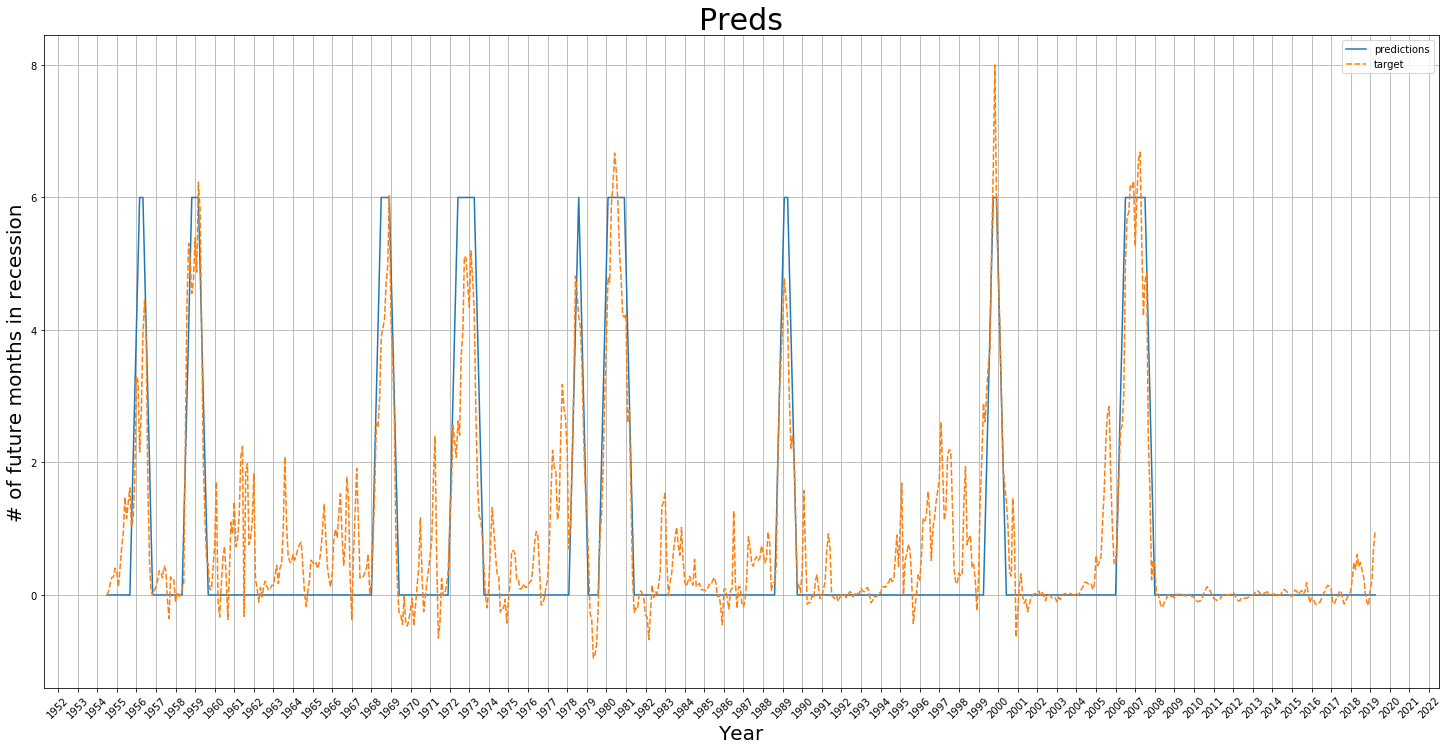

In [84]:
graph_results(time_steps_crop, y, pred_t)

In [47]:
dataset

array([[-0.08,  0.04,  1.05,  1.5 ,  0.  ],
       [-0.3 , -0.34,  0.68,  1.14,  0.  ],
       [-0.05, -0.03,  0.9 ,  1.32,  0.  ],
       ...,
       [-0.3 , -0.44, -0.57, -0.34,  0.  ],
       [-0.17, -0.35, -0.63, -0.49,  0.  ],
       [-0.16, -0.25, -0.49, -0.35,  0.  ]])

In [53]:
mean_squared_error(y_test, pred)

1.9954527900867434

In [51]:
mean_squared_error(y_train, pred_t)

1.5782477857505615